### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import importlib
import re

import matplotlib.pyplot as plt

import findatree.io as io
import findatree.descriptions as descriptions

plt.style.use(r'C:\Repos\findatree\own.mplstyle')

### Definitions

In [2]:
# Define directories where processed hdf5s are stored
dir_hdf5 = r"C:\Data\lwf\processed\2020\hdf5"

### Load crowns' features of all hdf5s

In [3]:
importlib.reload(io)

df, params_df = io.allhdf5s_crowns_features_to_dataframe(dir_hdf5, crowns_type='crowns_human')

### Inspect the features

#### Info: Dataset

In [4]:
print(params_df['io.allhdf5s_crowns_features_to_dataframe()_info'])
print()

n_crowns_mean = len(df) / len(np.unique(df.tnr))


# for key in params_df.keys():
    # print(f"tnr {key} contains {np.sum(np.array(df.tnr == key))} crowns")
print()
print(f"-> Total number of crowns: {len(df)}")
print(f"-> Mean number of crowns per tnr: {n_crowns_mean}")

print()
df.info()

['tnr11601: Only terr. features.']


-> Total number of crowns: 3895
-> Mean number of crowns per tnr: 30.91269841269841

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3895 entries, 0 to 3894
Columns: 266 entries, id to y_max_bbox_bright
dtypes: float32(249), int32(5), int64(1), object(2), uint16(9)
memory usage: 4.0+ MB


#### Info: Tree species

In [5]:
# Get unique species ids and counts
ids, counts = np.unique(df['ba'], return_counts=True)

# Sort from highest count to lowest count
sort_idx= np.flip(np.argsort(counts))
counts = counts[sort_idx]
ids = ids[sort_idx]

# Get dict that maps from ba to species name
ba_to_species = descriptions.species_id_to_name()
species_to_ba = descriptions.species_name_to_id()

print(f"Total number of trees: {len(df)}")
print()
print(f"{'id':<3}| {'name':<25}| {'count'}")
print('-'*40)
for id, count in zip(ids, counts):    
    print(f"{id:<3}| {ba_to_species[id]:<25}: {count}")

Total number of trees: 3895

id | name                     | count
----------------------------------------
134| Gemeine Kiefer           : 1544
118| Gemeine Fichte           : 945
20 | Rotbuche                 : 448
100| Weißtanne                : 207
48 | Traubeneiche             : 203
116| Europäische Lärche       : 117
51 | Stieleiche               : 93
10 | Gemeine Birke            : 44
22 | Gemeine Esche            : 43
7  | Schwarzerle              : 38
13 | Hainbuche                : 34
136| Douglasie                : 33
5  | Bergahorn                : 23
129| Schwarzkiefer            : 16
36 | Kirsche                  : 15
1  | Feldahorn                : 14
68 | Winterlinde              : 13
53 | Roteiche                 : 12
62 | Weide                    : 11
117| Japanische Lärche        : 11
35 | Aspe                     : 8
64 | Vogelbeere               : 7
133| Strobe                   : 4
4  | Spitzahorn               : 4
70 | Bergulme                 : 3
38 | Frühblühen

#### Plot histograms

0 232
1 285


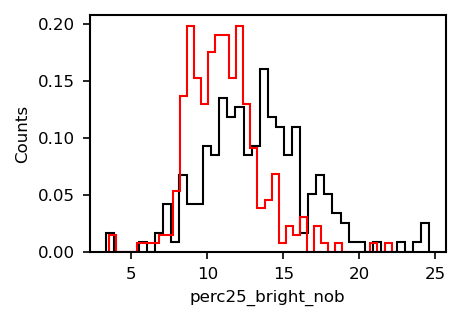

In [134]:
############### Define a query string to filter all features
query_strs = [
    'ba == 118 and sst in [0]',
    'ba == 118 and sst in [1]',
]

############### Which feature to plot
name = 'perc25_bright_nob'
bins = np.linspace(0.5,1,30)
bins = 40

############### Plot histograms
colors = ['k','r','b','magenta', 'gray']

f = plt.figure()
ax = f.add_subplot(111)

for i, query_str in enumerate(query_strs):
    x = df.query(query_str)[name]
    print(i, len(x))
    _ = ax.hist(
        x,
        bins=bins,
        density=True,
        histtype='step',
        ec=colors[i],
        )

_ = ax.set_ylabel('Counts')
_ = ax.set_xlabel(name)

#### Plotting: Definition

In [139]:
from typing import Dict

def plotter(
    data: Dict,
    specs: Dict,
):

    x = data['x'].copy()
    y = data['y'].copy()
    s = data['s'].copy()

    f = plt.figure(figsize= [4, 3])
    f.clear()
    ax = f.add_subplot(111)

    # Scatter plot
    _ = ax.scatter(
        x,
        y,
        s=s,
        fc='w',
        ec='k',
        alpha=0.7,
        lw=0.5,
        )

    # Unique x values and respective y means/stds
    x_unique = np.unique(x)
    y_unique = np.array([np.nanmean(y[np.where(x == xu)[0]]) for xu in x_unique])
    y_unique_err = np.array([np.nanstd(y[np.where(x == xu)[0]]) for xu in x_unique])

    # y distributions per unique x_vals with nans removed
    ydist_per_x_unique = [y[x == xu] for xu in x_unique]
    ydist_per_x_unique = [ydist_per_xu[np.isfinite(ydist_per_xu)] for ydist_per_xu in ydist_per_x_unique]


    # Violin plot for uniqe x values and respective y distributions
    poly_coll = ax.violinplot(
        ydist_per_x_unique,
        x_unique,
        points = 50,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.75,
    )['bodies']

    # Adjust violin plot sepcs
    for coll in poly_coll:
        coll.set_facecolor('k')
        coll.set_edgecolor('none')
        coll.set_alpha(0.3)
        coll.set_linewidth(1)

    # # Errorbar plot for uniqe x values and respective y means
    _ = ax.errorbar(
        x_unique,
        y_unique,
        y_unique_err,
        fmt='-s',
        ms=7,
        color='darkred',
        mec='k',
        mfc='darkred',
        capsize=6,
        )

    # Axis specs
    try:
        ax.set_xlim(specs['xlim'])
        ax.set_ylim(specs['ylim'])
        ax.set_title(specs['title'])
        ax.set_xlabel(specs['xlabel'])
        ax.set_ylabel(specs['ylabel'])
    except:
        pass

{'Gemeine Fichte': 118, 'Omorikafichte': 119, 'Sitkafichte': 120}


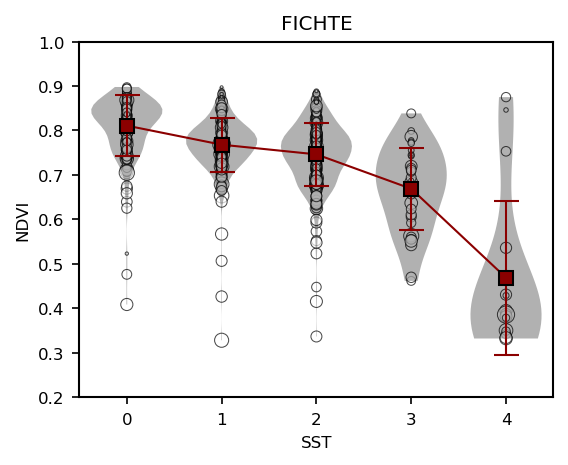

In [165]:
############### Select tree species
species_pattern = 'fichte'
species_select = dict([(key, val) for key, val in species_to_ba.items() if bool(re.search(species_pattern, key, re.IGNORECASE))])
bas = list(species_select.values())
print(species_select)

############### Define the query
query_str = 'ba in @bas'
query_str += ' and kkl in [1,2,3]'
query_str += ' and equivalent_diameter_area > 1'
query_str += ' and min_brightest_ndre > 0'
query_str += ' and eccentricity > 0'
query_str += ' and eccentricity < 1'

############### Which data to plot
ndvi = df.query(query_str)['perc25_brightest_ndvi'].values
ndvire = df.query(query_str)['perc25_brightest_ndvire'].values
ndre = df.query(query_str)['perc25_brightest_ndre'].values
grvi = df.query(query_str)['perc25_brightest_grvi'].values
sst = df.query(query_str)['sst'].values
light = df.query(query_str)['perc25_brightest_light'].values
chm = df.query(query_str)['max_chm'].values

data = {}
data['x'] = sst
data['y'] = ndvi
data['s'] = light * 1000

specs = {}
specs['title'] = species_pattern.upper()
specs['xlim'] = [-.5, 4.5]
specs['ylim'] = [0.2, 1]
specs['xlabel'] = 'sst'.upper()
specs['ylabel'] = 'ndvi'.upper()

plotter(data, specs)




# plt.savefig(os.path.join(save_dir, save_name), transparent=True)

#### Plot histograms

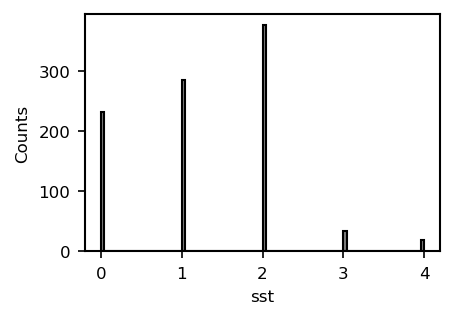

In [59]:
############### Define a query string to filter all features
query_str = 'ba == 118'

############### Which feature to plot
name = 'sst'

bins = 100

############### Plot histogram
f = plt.figure()
ax = f.add_subplot(111)
_ = ax.hist(
    df.query(query_str)[name],
    bins=bins,
    fc='grey',
    ec='black',
    )
_ = ax.set_ylabel('Counts')
_ = ax.set_xlabel(name)
# ax.set_xscale('log')
# ax.set_xticks(range(0,18))
# ax.set_xticklabels(range(0,18), fontsize=6)

# df.query('equivalent_diameter_area < 1')[['tnr', 'id', 'perc25_brightest_light', 'perc25_ndvi', 'max_light', 'perc75_light', 'max_chm','n_px', 'n_px_brightest', 'equivalent_diameter_area']]